# Zero-Shot Image Recognition with CLIP

**Implementation** Note:  
This notebook was developed using methodologies suggested by  
the DeepSeek-V3 language model (DeepSeek, 2024).

In [ ]:
# Install required libraries
# !pip install -q transformers torch pillow requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00


In [1]:
import requests
import torch
from torch.nn.functional import interpolate

from PIL import Image

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

from transformers import CLIPProcessor, CLIPModel, CLIPSegProcessor, CLIPSegForImageSegmentation

In [2]:
# Initialize model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

c:\Users\Valiu\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Valiu\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

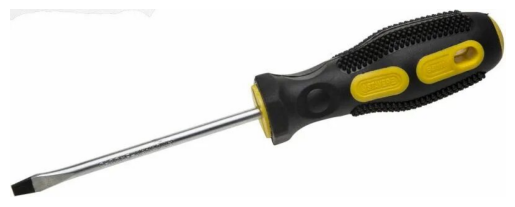

In [ ]:
# Use example image or paste your own URL
# url = "https://images.unsplash.com/photo-1573865526739-10659fec78a5"  # Cat image
url = "https://avatars.mds.yandex.net/i?id=16181ba90b059f04bc67cd0af5243a68_l-8169112-images-thumbs&n=13"
image = Image.open(requests.get(url, stream=True).raw)

# Display the image
plt.imshow(np.array(image))
plt.axis('off')
plt.show()

In [4]:
#@title Enter Candidate Labels {run: "auto"}
# Customize these labels for your use case
labels = ["cat", "dog", "wild animal", "car", "computer", "coffee mug"] #@param
labels = ["screwdriver", "pliers", "file", "cat"]

# Add prompt engineering for better results (CLIP benefits from this)
processed_labels = [f"a photo of a {label}" for label in labels]

In [5]:
# Process inputs and get predictions
inputs = processor(
    text=processed_labels,
    images=image,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    outputs = model(**inputs)

# Calculate probabilities
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).numpy()

In [6]:
# Simplified CLIP workflow
image_emb = model.get_image_features(inputs["pixel_values"])  # [1, 512]
text_emb = model.get_text_features(inputs["input_ids"])       # [4, 512] for 4 labels


Prediction probabilities:
screwdriver    : 99.97%
pliers         : 0.03%
file           : 0.00%
cat            : 0.00%

Predicted label: screwdriver


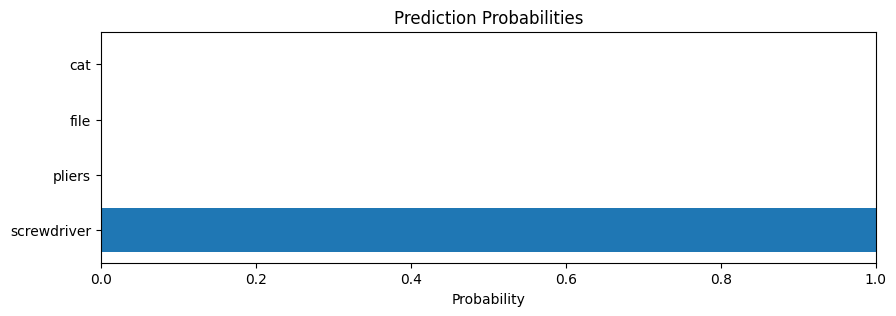

In [7]:
# Display results
print("\nPrediction probabilities:")
for label, prob in zip(labels, probs[0]):
    print(f"{label:<15}: {prob:.2%}")

predicted_label = labels[probs.argmax()]
print(f"\nPredicted label: {predicted_label}")

# Visualize probabilities
plt.figure(figsize=(10, 3))
plt.barh(labels, probs[0])
plt.title('Prediction Probabilities')
plt.xlabel('Probability')
plt.xlim([0, 1])
plt.show()

In [9]:
# Similarity calculation (cosine similarity)
logits_per_image = image_emb @ text_emb.T * model.logit_scale.exp()  # [1, 4]
probs = logits_per_image.softmax(dim=-1)